## Aggregating and Visualizing CFE River Discharge Data across Multiple Catchments

**Author:** [Javed Ali](https://www.javedali.net/) (University of Central Florida)  
    
**Date:** July 15, 2023

## Summary

This notebook performs the aggregation of river discharge data from various CSV files located within different directories, each representing a unique watershed. Each CSV file encompasses river discharge data for a specific storm event, catalogued against time. After the unification of data from different watersheds into a single pandas DataFrame, the script proceeds to calculate the average, minimum, and maximum discharges across all watersheds.

The merged and computed data is then visually represented using `matplotlib` to produce a detailed line plot. This plot represents the river discharge values over time for each watershed, while concurrently plotting the overall average, minimum, and maximum discharges for quick, at-a-glance comparison. Individual watershed data are plotted in light grey, whereas the average, minimum, and maximum discharges are accentuated with black, red, and blue lines respectively.

## Output

The generated plot is stored as a PNG file, adhering to the filename pattern `{watershed_ID}_discharge_{storm_name}.png`. The plot features a comprehensive legend, aimed at facilitating the interpretation of the represented data. Moreover, the plot title is set dynamically based on the last processed watershed ID and the corresponding storm name. This ensures that the context of each individual plot is clearly communicated to the viewer.


---


## Import the required libraries

In [2]:
# If watermark library is not install
!pip install watermark -q

In [1]:
# Importing the required libraries
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.figure import Figure

import pandas as pd
import os
import re

from tqdm.notebook import tqdm

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

%reload_ext watermark

In [2]:
%watermark

Last updated: 2023-07-17T19:45:20.319567+00:00

Python implementation: CPython
Python version       : 3.9.16
IPython version      : 8.14.0

Compiler    : GCC 11.3.0
OS          : Linux
Release     : 5.15.107+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 14
Architecture: 64bit



---

In [3]:
# check the current directory
os.getcwd()

'/home/jovyan/data/ngen-cfe-hydrological-model/notebooks/ngen'

## Merge all catchments for each storm and plot the discharge data

In [4]:
# Defining a helper function to extract the catchment ID from a filename
def get_catchment_id(filename):
    """
    Extracts catchment ID from the given filename.

    Args:
        filename : str : Name of the file.

    Returns:
        str : Catchment ID prefixed by 'catch-', suffixed by '-discharge', or None if no match.
    """
    # Regular expression search to find the catchment ID in the filename
    match = re.search(r'nex-(\d+)_output.csv', filename)
    
    # If a match is found, prefix 'catch-', suffix '-discharge' and return. If no match, return None.
    return 'catch-' + match.group(1) + '-discharge' if match else None



# Defining the main function to process and plot data
def process_and_plot_files(directory, ids_list):
    """
    Process and Merges all CSV files from a list of directories into one DataFrame and plot the data.

    Args:
        directory : str : The directory where the watershed directories are stored.
        ids_list : list : List of directories to process, named 'wb-{catchment_ID}'.

    Returns:
        None
    """
    # Initialize an empty DataFrame to store all data
    all_data = pd.DataFrame()
    
    # Iterating over each watershed ID in the provided list
    for wb_id in ids_list:
        # Constructing the path to the directory for the current watershed
        full_directory = os.path.join(directory, wb_id, 'outputs')

        # If the current watershed is 'wb-698891', handle it as a special case
        if wb_id == 'wb-698891':
            file_path = os.path.join(full_directory, 'nex-698887_output.csv')
            # Read the file and continue to the next iteration
            df = pd.read_csv(file_path, header=None, names=['index', 'time', 'catch-698887-discharge'])
            df = df.drop(columns=['index'])
            df['time'] = pd.to_datetime(df['time'])
            all_data = pd.merge(all_data, df, on='time', how='outer') if not all_data.empty else df
            continue

        # Creating a list of all CSV files in the directory that match our naming pattern
        csv_files = [f for f in os.listdir(full_directory) if f.endswith('.csv') and f.startswith('nex')]
        
        # Iterating over each CSV file in the directory
        for file in csv_files:
            
            # Extract the catchment ID from the file name
            catchment_id = get_catchment_id(file)
            
            # If the catchment ID in the filename matches the current watershed ID, process it
            if catchment_id.replace('catch-', '').replace('-discharge', '') == wb_id.replace('wb-', ''):
                file_path = os.path.join(full_directory, file)
                
                # Read the CSV file into a DataFrame
                df = pd.read_csv(file_path, header=None, names=['index', 'time', catchment_id])
                
                # Drop the 'index' column from the DataFrame
                df = df.drop(columns=['index'])
                
                # Convert the 'time' column to datetime format
                df['time'] = pd.to_datetime(df['time'])
                
                # If all_data is empty, copy df. Otherwise, merge df into all_data on 'time' column.
                all_data = pd.merge(all_data, df, on='time', how='outer') if not all_data.empty else df
                break
    
    
    # Save the merged data to a CSV file
    all_data.to_csv(f'{directory}/{directory}_merged_data.csv', index=False)

    # Identify the discharge columns
    discharge_cols = [col for col in all_data.columns if 'discharge' in col.lower()]
    
    # Calculate average, minimum, and maximum discharge
    all_data['average'] = all_data[discharge_cols].mean(axis=1)
    all_data['minimum'] = all_data[discharge_cols].min(axis=1)
    all_data['maximum'] = all_data[discharge_cols].max(axis=1)

    # Plot the data
    fig, ax = plt.subplots(figsize=(12, 7))

    # Define the colors for the special lines
    special_lines = {'average': 'black', 'minimum': 'blue', 'maximum': 'red'}

    # Plot the average, minimum, and maximum discharges
    for line, color in special_lines.items():
        ax.plot(all_data['time'], all_data[line], label=line, linewidth=2, linestyle='--', color=color)

    # Plot the discharge data for the discharge columns
    # for col in discharge_cols:
    #     ax.plot(all_data['time'], all_data[col], label=col.replace('-discharge', ''), color='lightgray')

    # Plot the discharge data for each catchment
    for col in discharge_cols:
        ax.plot(all_data['time'], all_data[col], color='lightgray')

        # Add annotation for the catchment ID
        last_value = all_data[col].iat[-1]
        last_time = all_data['time'].iat[-1]
        ax.annotate(col.replace('-discharge', ''), xy=(last_time, last_value), xycoords='data', color='darkgray', 
                    xytext=(5, -5), textcoords='offset points')
    
    # Set the title and labels
    ax.set_title(f'River Discharge during the {directory} in NYC', fontsize=18, y=1.03)
    ax.set_xlabel('Time', fontsize=14)
    ax.set_ylabel('River Discharge', fontsize=14)

    # Remove the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    # Increase the size of the x and y ticks labels
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    
    # Adding average, minimum, and maximum values to the plot as annotation
    for line, color in special_lines.items():
        value = all_data[line].iat[-1]
        pos = all_data['time'].iat[-1]
        ax.annotate(f'{line.capitalize()}: {value:.2f}', xy=(pos, value), xycoords='data', color=color, 
                    xytext=(-15, 10), textcoords='offset points', arrowprops=dict(arrowstyle="->", color=color))
    
    # Customize the legend
    # handles, labels = ax.get_legend_handles_labels()
    # h_special = [handles.pop(labels.index(l)) for l in special_lines]
    # l_special = [labels.pop(labels.index(l)) for l in special_lines]
    # h_discharge = handles
    # l_discharge = labels

    # Create two legends: one for special lines, another for discharge columns
    # legend_discharge = ax.legend(h_discharge, l_discharge, loc='upper left', bbox_to_anchor=(1.02, 0.4), title='Catchments', ncol=2)
    # legend_special = ax.legend(h_special, l_special, loc='upper left', bbox_to_anchor=(1.02, 0.8), title='Statistics')
    # ax.add_artist(legend_discharge)

    # Apply tight layout before saving
    plt.tight_layout()

    # Saving the figure with 400dpi
    fig.savefig(f"{directory}/{wb_id}_discharge_{directory}.png", dpi=400, bbox_inches='tight')

    # Displaying the plot
    plt.show()


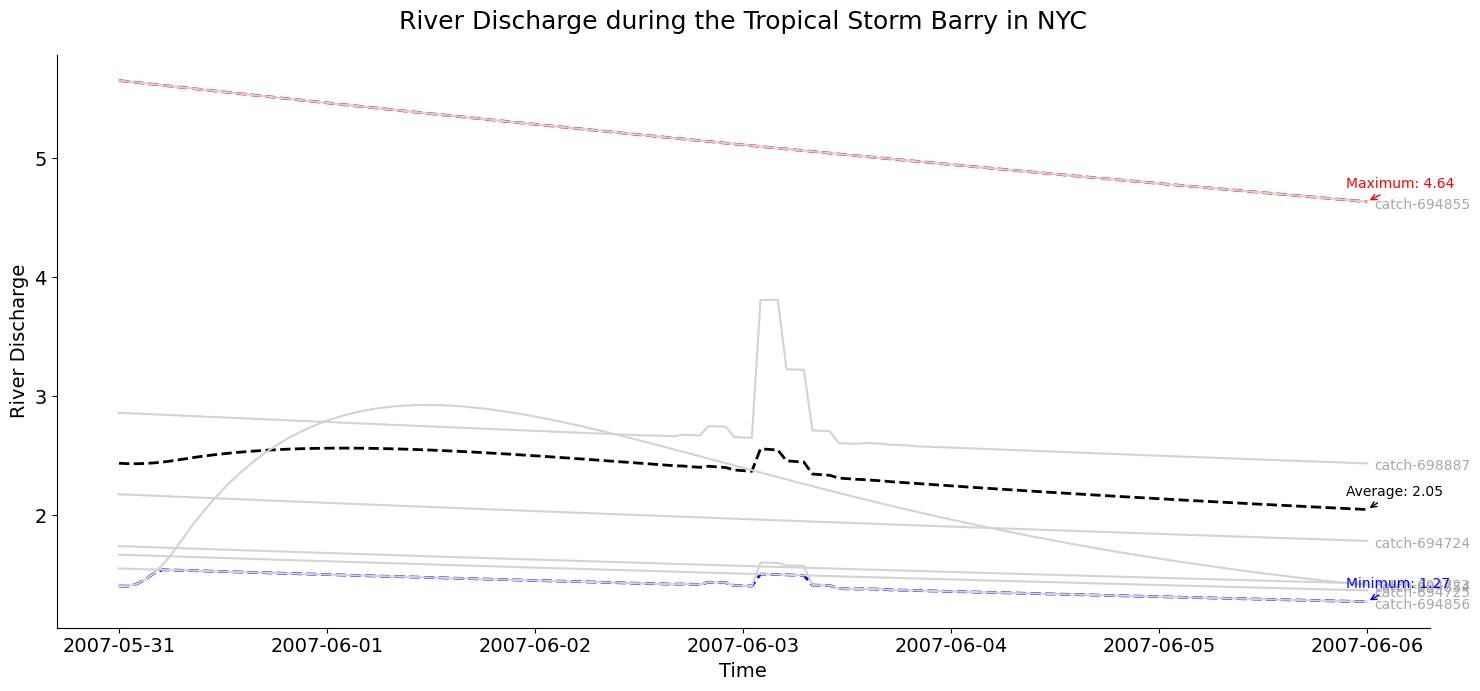

In [28]:
# Specify the storm name
storm_name = 'Tropical Storm Barry'

# List of directories to process
ids_list = ['wb-694856', 'wb-694725', 'wb-694855', 'wb-694724', 'wb-694854', 'wb-694723', 'wb-698891', 'wb-694722']

# Merge, process and plot all catchments river discharge
process_and_plot_files(storm_name, ids_list)

## ROUGH WORK

In [ ]:

    # Loop through each directory in the list
    for wb_id in ids_list:
        # Set the full directory path
        full_directory = os.path.join(directory, wb_id, 'outputs')

        # Get all CSV files in the directory that start with 'nex'
        csv_files = [f for f in os.listdir(full_directory) if f.endswith('.csv') and f.startswith('nex')]

        # Loop through each CSV file in the directory
        for file in csv_files:
            # Construct the file path
            file_path = os.path.join(full_directory, file)

            # Extract the catchment ID from the file name
            catchment_id = get_catchment_id(file)

            # If the catchment ID doesn't match the current watershed ID, skip this file
            if catchment_id.replace('catch-', '').replace('-discharge', '') != wb_id.replace('wb-', ''):
                continue

            # Read the CSV file into a DataFrame
            df = pd.read_csv(file_path, header=None, names=['index', 'time', catchment_id])
            
            # Rename the final column as per the catchment ID with '-discharge' suffix
            # df = df.rename(columns={df.columns[-1]: f'{catchment_id}-discharge'})

            # Drop the 'index' column from the DataFrame
            df = df.drop(columns=['index'])

            # Convert the 'time' column to datetime format
            df['time'] = pd.to_datetime(df['time'])

            # If all_data is empty, copy df. Otherwise, merge df into all_data on 'time' column.
            if all_data.empty:
                all_data = df
            else:
                all_data = pd.merge(all_data, df, on='time', how='outer')

In [ ]:
# def get_catchment_id(filename):
#     """
#     Extracts catchment ID from the given filename.

#     Args:
#         filename : str : Name of the file.

#     Returns:
#         str : Catchment ID prefixed by 'catch-', suffixed by '-discharge', or None if no match.
#     """
#     # Regular expression search to find the catchment ID in the filename
#     match = re.search(r'nex-(\d+)_output.csv', filename)
    
#     # If a match is found, prefix 'catch-', suffix '-discharge' and return. If no match, return None.
#     return 'catch-' + match.group(1) + '-discharge' if match else None

In [9]:
def get_catchment_id(filename):
    """
    Extracts catchment ID from the given filename.

    Args:
    filename : str : Name of the file.

    Returns:
    str : Catchment ID prefixed by 'catch-', suffixed by '-discharge', or None if no match.
    """

    # Regular expression search to find the catchment ID in the filename
    match = re.search(r'nex-(\d+)_output.csv', filename)
    
    # If a match is found, prefix 'catch-', suffix '-discharge' and return. If no match, return None.
    return 'catch-' + match.group(1) + '-discharge' if match else None

In [10]:
# List all CSV files in the directory that start with 'nex'
csv_files = [f for f in os.listdir() if f.endswith('.csv') and f.startswith('nex')]

In [12]:
# Initialize an empty DataFrame to store all data
all_data = pd.DataFrame()

# Iterate over each CSV file in the list
for file in tqdm(csv_files):
    # Read the CSV file into a DataFrame, specifying column names
    df = pd.read_csv(file, header=None, names=['index', 'time', 'river_discharge'])
    
    # Drop the 'index' column from the DataFrame
    df = df.drop(columns=['index'])

    # Extract catchment ID from the file name
    catchment_id = get_catchment_id(file)

    # Rename the 'output river discharge' column to the catchment ID with '-discharge' suffix
    df = df.rename(columns={'river_discharge': catchment_id})

    # If all_data is still empty, copy df. Otherwise, merge df into all_data on 'date and time' column.
    if all_data.empty:
        all_data = df
    else:
        all_data = pd.merge(all_data, df, on='time', how='outer')

# Write the merged DataFrame to a new CSV file
all_data.to_csv(f'../{wb_id}_merged_output.csv', index=False)


  0%|          | 0/1917 [00:00<?, ?it/s]

### Plot the data

In [21]:
data = all_data.copy()

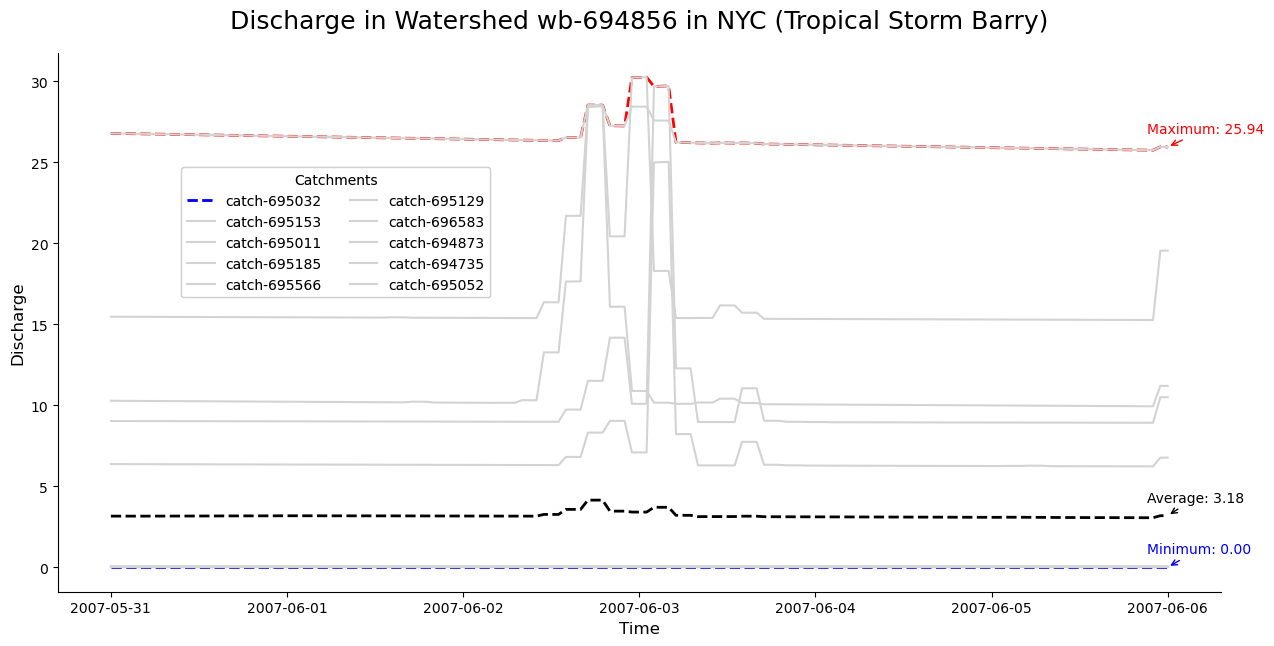

In [48]:
# Converting the 'time' column to datetime format
data['time'] = pd.to_datetime(data['time'])

# Identifying the discharge columns
discharge_cols = [col for col in data.columns if 'discharge' in col.lower()]

# Calculating the average, minimum, and maximum of the discharge columns
data['average'] = data[discharge_cols].mean(axis=1)
data['minimum'] = data[discharge_cols].min(axis=1)
data['maximum'] = data[discharge_cols].max(axis=1)

# Identifying the top 5 columns with the highest and lowest maximum discharge
max_values = data[discharge_cols].max()
top_5_highest = max_values.nlargest(5).index.tolist()
top_5_lowest = max_values.nsmallest(5).index.tolist()
subset_cols = top_5_highest + top_5_lowest

# Creating a new figure
fig, ax = plt.subplots(figsize=(15, 7))

# Defining the colors for the special lines
special_lines = {'average': 'black', 'minimum': 'blue', 'maximum': 'red'}

# Plotting the average, minimum, and maximum discharges
for line, color in special_lines.items():
    ax.plot(data['time'], data[line], label=line, linewidth=2, linestyle='--', color=color)

# Plotting the discharge data for the subset of columns
for col in subset_cols:
    ax.plot(data['time'], data[col], label=col.replace('-discharge', ''), color='lightgray')

# Set the title and labels
ax.set_title(f'Discharge in Watershed {wb_id} in NYC (Tropical Storm Barry)', fontsize=18, y=1.03)
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Discharge', fontsize=12)

# Removing the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Customizing the legend
handles, labels = ax.get_legend_handles_labels()
h_special = [handles.pop(labels.index(l)) for l in special_lines]
l_special = [labels.pop(labels.index(l)) for l in special_lines]
h_discharge = handles
l_discharge = labels

# Creating two legends: one for special lines, another for discharge columns
legend_discharge = ax.legend(h_discharge, l_discharge, loc='upper left', bbox_to_anchor=(0.10, 0.8), title='Catchments', ncol=2)
# legend_special = ax.legend(h_special, l_special, loc='upper left', bbox_to_anchor=(0.70, 0.8), title='Statistics')
ax.add_artist(legend_discharge)

# Adding average, minimum, and maximum values to the plot as annotation
for line, color in special_lines.items():
    value = data[line].iat[-1]
    pos = data['time'].iat[-1]
    ax.annotate(f'{line.capitalize()}: {value:.2f}', xy=(pos, value), xycoords='data', color=color, xytext=(-15, 10), 
                textcoords='offset points', arrowprops=dict(arrowstyle="->", color=color))

# Adjusting the layout
# fig.subplots_adjust(right=0.8)

# Save the figure 
fig.savefig(f"../{wb_id}_discharge_{storm_name}.png", dpi=400, bbox_inches='tight')

plt.show()